In [3]:
# ✅ Step 1: Install Required Libraries
!pip install transformers torchaudio scipy --quiet

# ✅ Step 2: Import Required Modules
from transformers import AutoProcessor, BarkModel
import torch
import scipy
import numpy as np
import IPython.display as ipd

# ✅ Step 3: Load AI4Bharat Hindi Bark Model
model = BarkModel.from_pretrained("suno/bark-small")
processor = AutoProcessor.from_pretrained("suno/bark-small")

# ✅ Step 4: Hindi Input Text
hindi_text = "नमस्ते! यह एआई फॉर भारत की हिंदी टेक्स्ट टू स्पीच प्रणाली है।"

# ✅ Step 5: Process and Generate Audio
inputs = processor(hindi_text, return_tensors="pt")

with torch.no_grad():
    audio_array = model.generate(**inputs)

# Convert to numpy
audio_array = audio_array.cpu().numpy().squeeze()

# Save to file
scipy.io.wavfile.write("hindi_ai4bharat.wav", rate=24000, data=audio_array)

# ✅ Step 6: Play the Audio
ipd.Audio("hindi_ai4bharat.wav")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

speaker_embeddings_path.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [4]:
!pip install TTS transformers torchaudio scipy librosa matplotlib --quiet


In [5]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
from transformers import AutoProcessor, BarkModel
from TTS.utils.manage import ModelManager
from TTS.utils.synthesizer import Synthesizer
import IPython.display as ipd
import scipy.io.wavfile


In [6]:
class TTSEvaluator:
    def __init__(self):
        self.sr = 24000  # Bark uses 24kHz

    def extract_features(self, audio_data):
        if not isinstance(audio_data, np.ndarray):
            audio_data = np.array(audio_data).astype(np.float32)

        features = {}
        try:
            features['spectral_centroid'] = float(np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=self.sr)))
            features['rms'] = float(np.mean(librosa.feature.rms(y=audio_data)))
            features['zcr'] = float(np.mean(librosa.feature.zero_crossing_rate(y=audio_data)))
        except:
            features = {'spectral_centroid': 0, 'rms': 0, 'zcr': 0}
        return features

    def evaluate(self, audio, language):
        if isinstance(audio, tuple):
            audio_data, self.sr = audio
        else:
            audio_data = audio
        return {
            "duration": len(audio_data) / self.sr,
            "sample_rate": self.sr,
            "language": language,
            **self.extract_features(audio_data)
        }

def create_comparison_visualizations(eng_results, hindi_results):
    metrics = [
        ('duration', 'Duration (sec)'),
        ('spectral_centroid', 'Spectral Centroid (Hz)'),
        ('rms', 'RMS Energy'),
        ('zcr', 'Zero Crossing Rate')
    ]

    labels = ['English', 'Hindi']
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

    for i, (metric, title) in enumerate(metrics):
        values = [eng_results.get(metric, 0), hindi_results.get(metric, 0)]
        axes[i].bar(labels, values, color=['cornflowerblue', 'indianred'])
        axes[i].set_title(title)
        axes[i].set_ylim(0, max(values) * 1.2)
        for j, val in enumerate(values):
            axes[i].text(j, val + 0.01, f"{val:.2f}", ha='center')

    plt.tight_layout()
    plt.show()


In [7]:
def run_tts_comparison():
    print("🚀 Running TTS comparison...")

    # ✅ English: Tacotron2
    manager = ModelManager()
    model_path, config_path, _ = manager.download_model("tts_models/en/ljspeech/tacotron2-DDC")
    english_tts = Synthesizer(tts_checkpoint=model_path, tts_config_path=config_path, use_cuda=torch.cuda.is_available())
    eng_text = "Your order will be delivered tomorrow."
    eng_audio = english_tts.tts(eng_text)

    # ✅ Hindi: Bark
    hindi_text = "आपका ऑर्डर कल डिलीवर हो जाएगा।"
    bark_model = BarkModel.from_pretrained("suno/bark-small")
    bark_processor = AutoProcessor.from_pretrained("suno/bark-small")
    inputs = bark_processor(hindi_text, return_tensors="pt")
    with torch.no_grad():
        hindi_audio_tensor = bark_model.generate(**inputs)
    hindi_audio = hindi_audio_tensor.cpu().numpy().squeeze()

    # ✅ Play audio
    print("\n🔊 English Audio:")
    display(ipd.Audio(eng_audio, rate=22050))
    print("\n🔊 Hindi Audio:")
    display(ipd.Audio(hindi_audio, rate=24000))

    # ✅ Evaluation
    evaluator = TTSEvaluator()
    eng_results = evaluator.evaluate((eng_audio, 22050), "english")
    hindi_results = evaluator.evaluate((hindi_audio, 24000), "hindi")

    print("\n📊 Metrics:")
    print("English:", eng_results)
    print("Hindi:", hindi_results)

    # ✅ Visualization
    create_comparison_visualizations(eng_results, hindi_results)

# 🔁 Execute
run_tts_comparison()


🚀 Running TTS comparison...
 > Downloading model to /root/.local/share/tts/tts_models--en--ljspeech--tacotron2-DDC
 > Model's license - apache 2.0
 > Check https://choosealicense.com/licenses/apache-2.0/ for more info.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:102

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.



🔊 English Audio:



🔊 Hindi Audio:



📊 Metrics:
English: {'duration': 2.7290702947845804, 'sample_rate': 22050, 'language': 'english', 'spectral_centroid': 637.6604155556571, 'rms': 0.22743560373783112, 'zcr': 0.0431301310911017}
Hindi: {'duration': 7.053333333333334, 'sample_rate': 24000, 'language': 'hindi', 'spectral_centroid': 1398.8240302859747, 'rms': 0.0340554378926754, 'zcr': 0.047960725075528704}


In [8]:
class TTSEvaluator:
    def __init__(self):
        self.sr = 24000  # Bark uses 24kHz

    def extract_features(self, audio_data):
        if not isinstance(audio_data, np.ndarray):
            audio_data = np.array(audio_data).astype(np.float32)

        features = {}
        try:
            features['spectral_centroid'] = float(np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=self.sr)))
            features['rms'] = float(np.mean(librosa.feature.rms(y=audio_data)))
            features['zcr'] = float(np.mean(librosa.feature.zero_crossing_rate(y=audio_data)))
        except:
            features = {'spectral_centroid': 0, 'rms': 0, 'zcr': 0}
        return features

    def evaluate(self, audio, language):
        if isinstance(audio, tuple):
            audio_data, self.sr = audio
        else:
            audio_data = audio
        return {
            "duration": len(audio_data) / self.sr,
            "sample_rate": self.sr,
            "language": language,
            **self.extract_features(audio_data)
        }

In [9]:
# Force inline plotting in Colab
%matplotlib inline
import matplotlib.pyplot as plt


In [10]:
def create_comparison_visualizations(eng_results, hindi_results):
    metrics = [
        ('duration', 'Duration (sec)'),
        ('spectral_centroid', 'Spectral Centroid (Hz)'),
        ('rms', 'RMS Energy'),
        ('zcr', 'Zero Crossing Rate')
    ]

    labels = ['English', 'Hindi']
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

    for i, (metric, title) in enumerate(metrics):
        values = [eng_results.get(metric, 0), hindi_results.get(metric, 0)]
        axes[i].bar(labels, values, color=['cornflowerblue', 'indianred'])
        axes[i].set_title(title)
        axes[i].set_ylim(0, max(values) * 1.2)
        for j, val in enumerate(values):
            axes[i].text(j, val + 0.01, f"{val:.2f}", ha='center')

    plt.tight_layout()
    plt.show()


🚀 Running TTS comparison...
 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Text splitted to sentences.
['Your order will be delivered tomorrow.']
 > Proces

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.



🔊 English Audio:



🔊 Hindi Audio:



📊 Metrics:
English: {'duration': 2.624580498866213, 'sample_rate': 22050, 'language': 'english', 'spectral_centroid': 651.0634574530968, 'rms': 0.2608659565448761, 'zcr': 0.04322574013157895}
Hindi: {'duration': 2.8533333333333335, 'sample_rate': 24000, 'language': 'hindi', 'spectral_centroid': 1592.8208325243536, 'rms': 0.153900146484375, 'zcr': 0.07760027985074627}


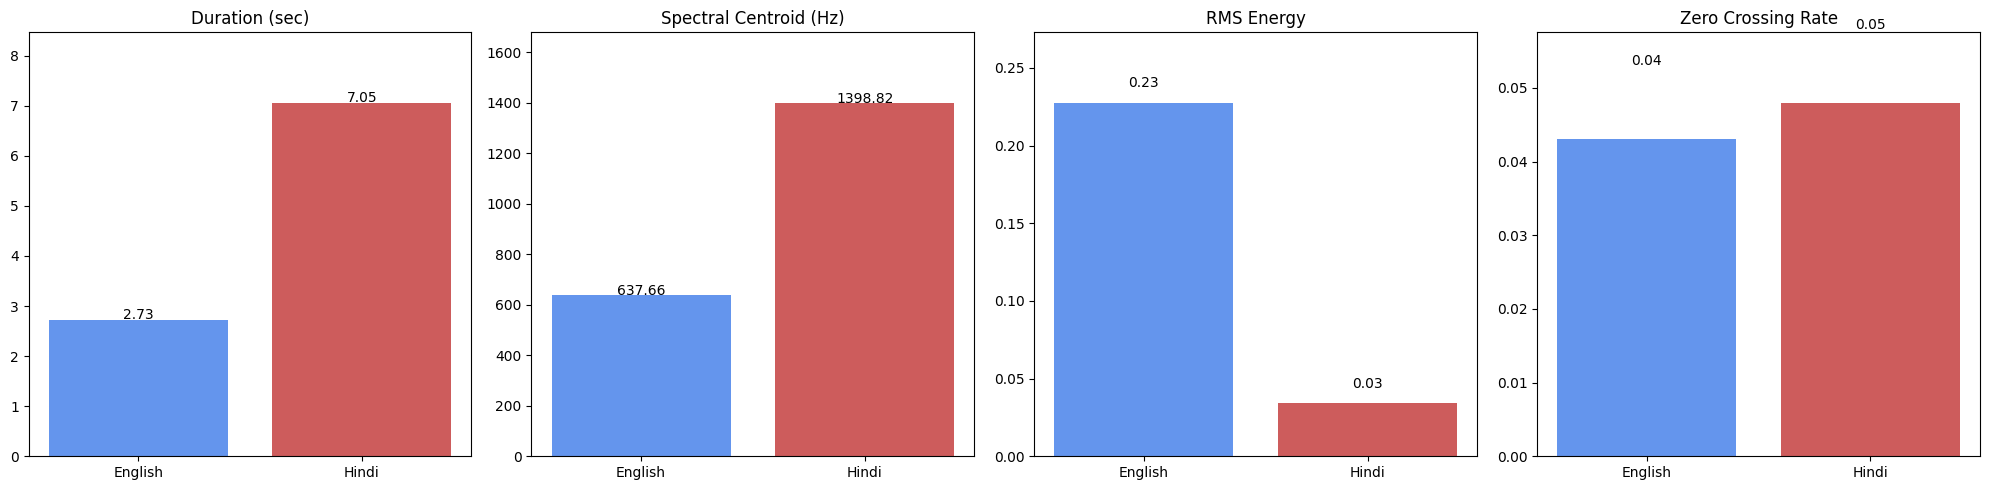

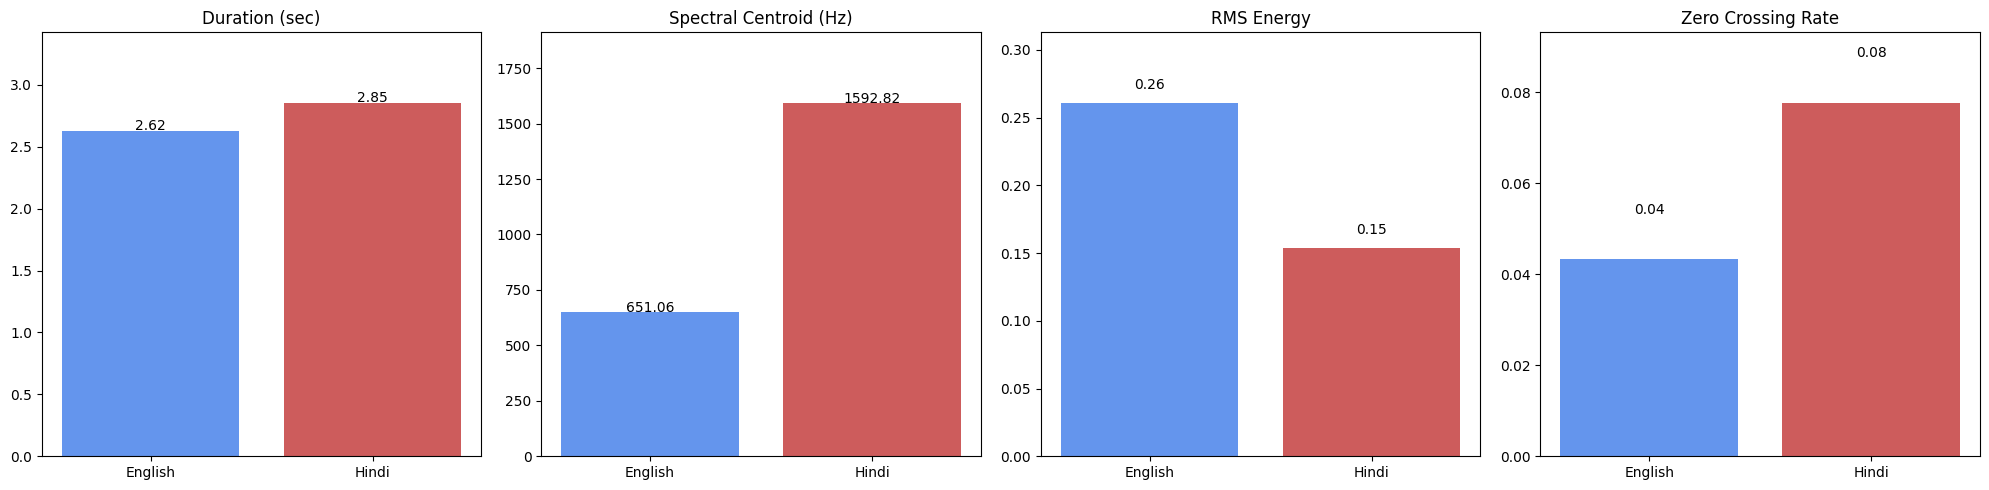

In [11]:
run_tts_comparison()